In [ ]:
!pip install -q opencv-python-headless
!pip install -q matplotlib
!pip install -q tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request
import zipfile
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
os.makedirs('weights', exist_ok=True)

if not os.path.exists('weights/yolov3.weights'):
    print("Downloading YOLOv3 weights...")
    # Downloading yolov3.weights from an alternative source that is accessible.
    urllib.request.urlretrieve('https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov3.weights', 'weights/yolov3.weights')

if not os.path.exists('weights/yolov3.cfg'):
    print("Downloading YOLOv3 config...")
    urllib.request.urlretrieve('https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg', 'weights/yolov3.cfg')

if not os.path.exists('weights/coco.names'):
    print("Downloading COCO labels...")
    urllib.request.urlretrieve('https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names', 'weights/coco.names')

In [ ]:
# Load Class Names
# ========================================

with open('weights/coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]


# ========================================
# Load YOLOv3 Model from OpenCV
# ========================================

net = cv2.dnn.readNetFromDarknet('weights/yolov3.cfg', 'weights/yolov3.weights')
layer_names = net.getLayerNames()
out_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]





In [ ]:
def detect_objects(img_path):
    img = cv2.imread(img_path)
    height, width = img.shape[:2]

    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    outputs = net.forward(out_layers)

    boxes = []
    confidences = []
    class_ids = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    font = cv2.FONT_HERSHEY_PLAIN
    colors = np.random.uniform(0, 255, size=(len(classes), 3))

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confidences[i]
            color = colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, f"{label} {confidence:.2f}", (x, y - 5), font, 1, color, 1)

    return img




In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

net = cv2.dnn.readNetFromDarknet('weights/yolov3.cfg', 'weights/yolov3.weights')

layer_names = net.getLayerNames()

out_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]
with open("weights/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
def show_result(image_path):
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    # Convert image to blob as YOLOv3 input format
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)

    # Set input to the model
    net.setInput(blob)

    # Run forward pass through YOLO network
    outputs = net.forward(out_layers)

    boxes, confidences, class_ids = [], [], []

    # Process each detection output from YOLO
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5:
                # Convert center coordinates to top-left corner
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Non-max suppression to remove overlapping boxes
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Draw thick rectangles and bold labels
    for i in indices.flatten():
        x, y, w, h = boxes[i]
        label = f"{classes[class_ids[i]]}: {confidences[i]:.2f}"

        # Use bold color and thick border
        color = (0, 0, 255)  # Red
        thickness = 3        # Thick bounding box

        cv2.rectangle(image, (x, y), (x + w, y + h), color, thickness)

        # Text: bold and more visible
        font_scale = 0.7
        font = cv2.FONT_HERSHEY_SIMPLEX
        (text_width, text_height), _ = cv2.getTextSize(label, font, font_scale, 2)
        cv2.rectangle(image, (x, y - text_height - 6), (x + text_width, y), color, -1)
        cv2.putText(image, label, (x, y - 5), font, font_scale, (255, 255, 255), 2)

    # Convert BGR to RGB for display in matplotlib
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title("Darknet53 with yolov3")
    plt.axis("off")
    plt.show()


In [ ]:
import numpy as np

def calculate_iou_np(box1, box2):
    """Calculates IoU using NumPy."""
    x1_inter = np.maximum(box1[0], box2[0])
    y1_inter = np.maximum(box1[1], box2[1])
    x2_inter = np.minimum(box1[2], box2[2])
    y2_inter = np.minimum(box1[3], box2[3])

    inter_area = np.maximum(0, x2_inter - x1_inter + 1) * np.maximum(0, y2_inter - y1_inter + 1)

    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

def calculate_precision_recall_np(detections, ground_truth, iou_threshold=0.5):
    """Calculates precision/recall using NumPy."""
    tp = 0
    fp = 0
    fn = 0

    gt_matched = [False] * len(ground_truth)  # Track matched ground truth boxes

    for det_box in detections:
        det_x1, det_y1, det_x2, det_y2, det_conf, det_class_id = det_box
        best_iou = 0
        best_gt_index = -1

        for gt_index, gt_box in enumerate(ground_truth):
            gt_x1, gt_y1, gt_x2, gt_y2, gt_class_id = gt_box
            if det_class_id == gt_class_id and not gt_matched[gt_index]:
                iou = calculate_iou_np([det_x1, det_y1, det_x2, det_y2], [gt_x1, gt_y1, gt_x2, gt_y2])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_index = gt_index

        if best_iou >= iou_threshold:
            tp += 1
            gt_matched[best_gt_index] = True
        else:
            fp += 1

    fn = sum(not matched for matched in gt_matched)  # Count unmatched ground truth

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    return precision, recall

def calculate_ap_np(precision, recall):
    """Calculates AP using NumPy."""

    mpre = np.concatenate(([0.], precision, [0.]))
    mrec = np.concatenate(([0.], recall, [1.]))

    for i in range(mpre.size - 2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i + 1])

    i = np.where(mrec[1:] != mrec[:-1])[0]
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

def calculate_map_np(detections_list, ground_truth_list, n_classes, iou_threshold=0.5):
    """Calculates mAP using NumPy."""

    ap_values = []
    for class_id in range(n_classes):
        class_detections = []
        class_ground_truth = []

        for img_detections, img_ground_truth in zip(detections_list, ground_truth_list):
            class_detections.extend([det for det in img_detections if det[5] == class_id])
            class_ground_truth.extend([gt for gt in img_ground_truth if gt[4] == class_id])

        class_detections.sort(key=lambda x: x[4], reverse=True)  # Sort by confidence

        if not class_ground_truth:
            ap_values.append(0.0)
            continue

        precision_values = []
        recall_values = []
        for det_box in class_detections:
            precision, recall = calculate_precision_recall_np([det_box], class_ground_truth, iou_threshold)
            precision_values.append(precision)
            recall_values.append(recall)

        ap = calculate_ap_np(precision_values, recall_values)
        ap_values.append(ap)

    mean_ap = np.mean(ap_values) if ap_values else 0
    return mean_ap

In [ ]:
show_result("/content/detections.gif")

Error: Could not load image from /content/detections.gif. Check the file path and ensure it is a valid image.


In [ ]:
!pip install imageio

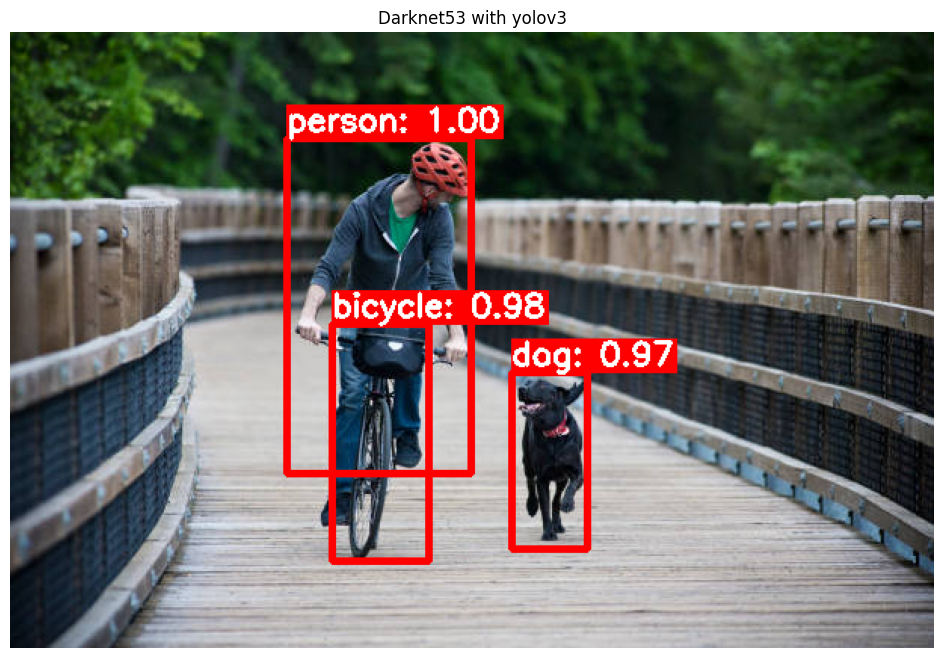

In [ ]:
show_result("/content/istockphoto-841941006-612x612.jpg")
